In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Empirical growth rates

/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


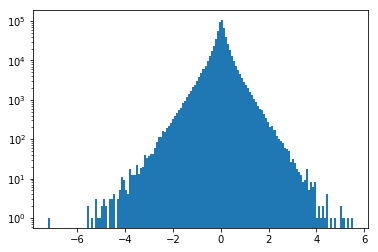

0.4524525317965355

In [2]:
data_path = './../../data/processed/'

df = pd.read_csv(data_path + 'ID_Y.csv')
df = df.loc[df.IMPORT == 0]

cuadro = df.set_index(['ID', 'YEAR'])[['VART']].unstack()

# Firms present in at least some time periods
cuadro = cuadro.loc[cuadro.count(1) > 12]
cuadro_rolled = cuadro

annual_logdiff = np.log10(cuadro_rolled).diff(1, axis = 1).replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna(how = 'all')
annual_log = np.log10(cuadro_rolled.reindex(annual_logdiff.index))

annual_log.columns = annual_log.columns.set_levels(annual_log.columns.levels[0].str.replace('VART', 'annual_log'), level=0)
annual_logdiff.columns = annual_logdiff.columns.set_levels(annual_logdiff.columns.levels[0].str.replace('VART', 'annual_logdiff'), level=0)

df_concat = pd.concat([annual_log, annual_logdiff], axis = 1)

df_level_g = df_concat.stack()

g_rates = df_level_g.dropna()['annual_logdiff']
plt.hist(g_rates.values, 150)
plt.yscale('log')
plt.show()
g_rates.std()

## split into quantiles

In [3]:
df = pd.read_csv('./../../data/processed/ID_Y.csv')
df = df.loc[df.IMPORT == 0]

# plt.hist(df.groupby(['ID','IMPORT']).count()['YEAR'], range(15))
cuadro = df.set_index(['ID', 'YEAR'])['VART'].unstack().dropna()

In [4]:
Q = 10

cuadro['quantile'] = pd.cut(cuadro.mean(1).sort_values().cumsum(), Q)
# cuadro['quantile'].value_counts() #N.

# Sizes
sizes = cuadro.groupby('quantile').mean().mean(1)

sizes_median = cuadro.groupby('quantile').median().median(1)

# N
N = cuadro['quantile'].value_counts()

# firm level Std
std_q = []
for q in cuadro['quantile'].unique().sort_values():
    q_chunk = cuadro.loc[cuadro['quantile'] == q].drop('quantile', axis = 1)
    log_chunk = np.log10(q_chunk).replace(-np.inf, np.nan).replace(np.inf, np.nan)
    std_q += [log_chunk.diff(axis = 1).dropna(axis = 1, how = 'all').stack().std()]

std = pd.Series(std_q, index = cuadro['quantile'].unique(), name='std').sort_index()

quantile_total = pd.DataFrame(cuadro.groupby('quantile').sum().values,
                              index = range(Q), columns=range(1997, 2014))

quantile_diff = np.log10(quantile_total).T.diff()
quantile_diff_dem = (quantile_diff.T - quantile_diff.median(1)).T

/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


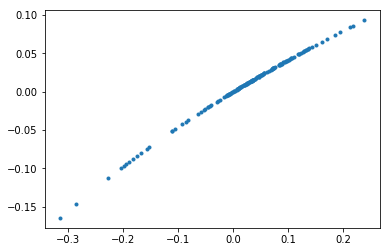

In [5]:
y = np.log10(quantile_total).T.diff().dropna().values.flatten()
# it is about 1/2 of using pct change
x = quantile_total.T.pct_change().dropna().values.flatten()

plt.plot(x, y, marker = '.', lw = 0)

In [6]:
# cuadro.groupby('quantile').std()#.mean(1)
# df_concat

In [7]:
# quantile_diff_dem.plot(marker = '.')

In [8]:
long = quantile_diff_dem.T.stack()
# long = long.head()
long.index = long.index.get_level_values(0)#.plot()

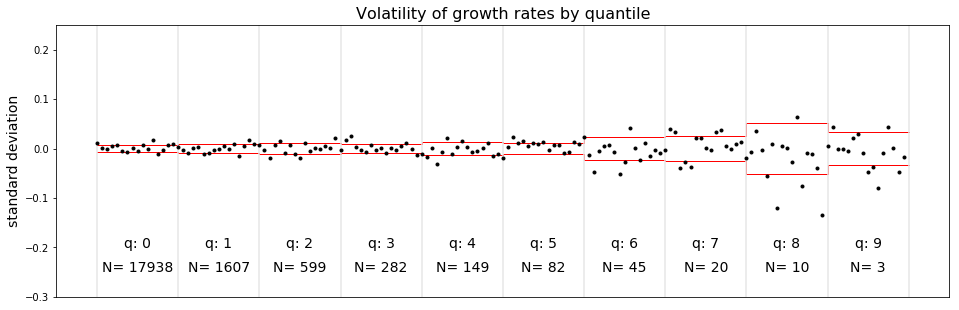

In [51]:
fig, ax = plt.subplots(1, figsize = (16, 5))

ax.plot(range(len(long)), long, lw = 0, marker = '.', c =  'k')

stds = long.groupby(level = 0).std()
stds = stds.append(pd.Series({len(stds): stds.loc[len(stds) - 1]}))

ax.step((2013 - 1997)*stds.index, stds, where='post', label='post', color = 'r', lw = 1, zorder = -20)
ax.step((2013 - 1997)*stds.index, -stds, where='post', label='post', color = 'r', lw = 1, zorder = -20)

for l in range(Q + 1):
    ax.axvline((2013 - 1997)*l, c = '.9', linestyle = '-', zorder = -10) 

ax.set_ylim(-.3, .25)

for q in range(Q):
#     print()
    ax.annotate('q: '+str(q), 
            xy=(16*q + 8, -.2), ha="center", fontsize=14)
    ax.annotate('N= '+str(N.iloc[q]), 
            xy=(16*q + 8, -.25), ha="center", fontsize=14)

ax.set_xticks([])
ax.set_ylabel('standard deviation', fontsize = 14)
ax.set_title('Volatility of growth rates by quantile', fontsize = 16)
plt.savefig('./../../../thesis_writing/figures/volatilities_quantile.png', dpi = 300)
plt.show()

## Simulate volatility
### Empirical, size dependent

In [10]:
# g_rates_val = g_rates.values

result_list = []
g_rates_result_list = []

for bin_, n in enumerate(N.values):
    bin_s = np.log10(sizes_median.iloc[bin_])
    g_rates = df_level_g.loc[abs(df_level_g.annual_log - bin_s) < .25].dropna()['annual_logdiff'].clip(-1, 1)
    g_rates_result_list += [pd.Series(g_rates).describe()]

    g_rates_val = g_rates.values
#     print(n)
    mu0 = bin_s
    x0 = mu0*np.ones(n)

    t_std = []
    for m in range(300):
        t = []
        for yrs in range((2013 - 1997)):
        #     x1 = np.random.normal(0, 0.2, n)
            x1 = np.random.choice(g_rates_val, n)
    #         t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]
            t += [np.log10(np.power(10, x0 + x1).sum()) - np.log10(n) - mu0]
        t_std += [np.array(t)[1:].std()]
    
    s1 = np.array(t_std)
    result_list += [pd.Series(s1).describe()]

result = pd.DataFrame(pd.concat(result_list, axis = 1))
result.columns = N.values
result = result.T

17938
1607
599
282
149
82
45
20
10
3


### Gaussian

In [11]:
# g_rates_val = g_rates.values

result_list = []
g_rates_result_list = []

for bin_, n in enumerate(N.values):
    bin_s = np.log10(sizes_median.iloc[bin_])
    bin_std = std.iloc[bin_]
#     print(n)
    mu0 = bin_s
    x0 = mu0*np.ones(n)

    t_std = []
    for m in range(300):
        t = []
        for yrs in range((2013 - 1997)):
            x1 = np.random.normal(0, bin_std, n)
#             x1 = np.random.choice(g_rates_val, n)
    #         t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]
            t += [np.log10(np.power(10, x0 + x1).sum()) - np.log10(n) - mu0]
        t_std += [np.array(t)[1:].std()]
    
    s1 = np.array(t_std)
    result_list += [pd.Series(s1).describe()]
result2 = pd.DataFrame(pd.concat(result_list, axis = 1))
result2.columns = N.values
result2 = result2.T

17938
1607
599
282
149
82
45
20
10
3


### Empirical, size INdependent

In [21]:
# g_rates_val = g_rates.values

result_list = []
g_rates_result_list = []

for bin_, n in enumerate(N.values):
    bin_s = np.log10(sizes_median.iloc[bin_])
    g_rates = df_level_g.dropna()['annual_logdiff'].clip(-1, 1)
    g_rates_result_list += [pd.Series(g_rates).describe()]

    g_rates_val = g_rates.values
#     print(n)
    mu0 = bin_s
    x0 = mu0*np.ones(n)

    t_std = []
    for m in range(300):
        t = []
        for yrs in range((2013 - 1997)):
        #     x1 = np.random.normal(0, 0.2, n)
            x1 = np.random.choice(g_rates_val, n)
    #         t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]
            t += [np.log10(np.power(10, x0 + x1).sum()) - np.log10(n) - mu0]
        t_std += [np.array(t)[1:].std()]
    
    s1 = np.array(t_std)
    result_list += [pd.Series(s1).describe()]

result3 = pd.DataFrame(pd.concat(result_list, axis = 1))
result3.columns = N.values
result3 = result3.T

In [12]:

# result.head()

# fig, ax = plt.subplots(1, figsize = (7, 6))
# x = N.values
# ax.plot(x, result['75%'], c = '.7')
# ax.plot(x, result['50%'], c = '.7', marker = '.')
# ax.plot(x, result['25%'], c = '.7')

# plt.xscale('log')
# # plt.ylim(0, .2)
# plt.show()

In [13]:
def distrib(sigmas):
    result = np.log10(np.array([np.power(10, np.random.normal(0, s, 40000)) for s in sigmas]).sum(0)/len(sigmas))
    return result

### ns = np.round((.3/y)**2)

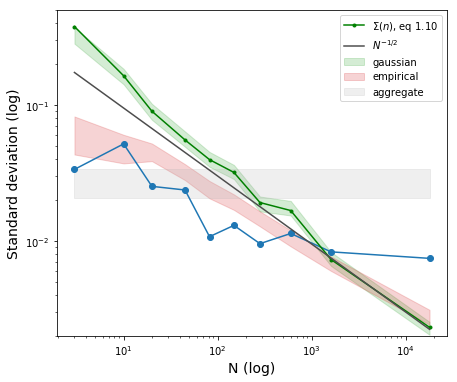

In [52]:

fig, ax = plt.subplots(1, figsize = (7, 6))
x = N.values
y = stds[:-1].values
# ax.plot(x = N.values, y = stds[:-1].values, marker = 'o')
ax.plot(x, y, marker = 'o')

# # Gaussian expectation with the sigma of each bin
sigma = std
sigma_correg = np.sqrt((np.exp(sigma**2))*(np.exp(sigma**2) - 1))
ax.plot(x, sigma_correg/np.sqrt(x), marker = '.', c = 'g', label = r'$\Sigma(n)$, eq 1.10') # we can confirm it's a good approx
# ax.plot(x, std/np.sqrt(x), marker = '.', c= 'g')

# this is from using GAUSSIAN growth rates around each size to simulate the std
ax.fill_between(x, result2['25%'], result2['75%'], color = '#2ca02c', alpha = .2, label = 'gaussian')

# this is from using EMPIRICAL growth rates around each size to simulate the std
ax.fill_between(x, result['25%'], result['75%'], color = '#d62728', alpha = .2, label = 'empirical')

# # this is from using EMPIRICAL growth rates around each size to simulate the std
# ax.fill_between(x, result3['25%'], result3['75%'], color = '#9467bd', alpha = .2, label = 'empirical \n constant g')

# This is the simulated (distrib function) std of the dataset made of all quantiles
# ax.axhline(np.std(distrib(stds.values)), c = '.5', linestyle = ':')

# This is the aggregate std (the quantity we want to explain). However it could have A LOT of error
# We could estimate some error bar under gaussian hypothesis
agg_volatility = np.log10(cuadro.sum()).diff().dropna()
ax.fill_between(x, agg_volatility.std(), agg_volatility.drop(2009).std(), color = '.7', alpha = .2, label = 'aggregate')

# If it doesnt coincide with the grey dotted above it's because quantiles are not 'lognormal'
# which we have kind of seem becuse the grey line is better than the greens

# # custom
# ax.plot(x, .108/np.sqrt(x), linestyle = '--', c = 'r', zorder = 10) #.118 lets the whole dataset std match the empirical blue
# ax.plot(x, .765/np.sqrt(x), linestyle = '--', c = 'r', zorder = 10) #
ax.plot(x, .3/np.sqrt(x), linestyle = '-', c = '.3', zorder = 10, label = r'${N}^{-1/2}$') #

ax.set_xlabel('N (log)', fontsize = 14)
ax.set_ylabel('Standard deviation (log)', fontsize = 14)
ax.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.002, .5)

plt.savefig('./../../../thesis_writing/figures/quantiles_std_bands.png', dpi = 300)

plt.show()

In [15]:
# colors

#1f77b4
#ff7f0e
#2ca02c
#d62728
#9467bd
#8c564b
#e377c2
#7f7f7f
#bcbd22
#17becf

In [16]:
##### DEBUG
# bin_s = np.log10(sizes.iloc[bin_])
# g_rates = df_level_g.loc[abs(df_level_g.annual_log - bin_s) < .5].dropna()['annual_logdiff']
    

# plt.hist(np.log10(firm_sample.drop('quantile', axis = 1)).diff(axis = 1).dropna(axis = 1).values.flatten(), 150, alpha = .5)
# plt.yscale('log')

# plt.hist(g_rates.sample(frac = .06).values, 150, alpha = .5)
# plt.show()

In [17]:
np.std(distrib(y))

0.007526700827370346

In [18]:
# The empirical sigmas of deciles are something like:
sigma_deciles = .765/np.sqrt(x)
sigma_deciles
dist = distrib(sigma_deciles)
np.std(dist)

# # This is the simulated (distrib function) std of the dataset made of all quantiles
# ax.axhline(np.std(distrib(y)), c = '.5', linestyle = ':')

0.07668546258646074

In [19]:
aggv = np.log10(cuadro.sum()).diff().dropna()

In [20]:
aggv.drop(2009).std()

0.02062185424748409